<a name="section-preprocessing"></a><h2 style="color:rgb(0,120,170)">1. Pre-processing & Feature Extraction</h2>

In [229]:
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/atrophian_strength/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
train = pd.read_csv('./thedeep.subset.train.txt', header=None)
test = pd.read_csv('./thedeep.subset.test.txt', header=None)
validation = pd.read_csv('./thedeep.subset.validation.txt', header=None)

# First look at the data

When looking at the data, we can clearly see that the first column is simply a counter, therefore we can disregard it. Second column is the data itself and the last one are the labels.

The next step, is to split the dataset into text and labels.

In [ ]:
train_corpus, y_train = train.iloc[:, 1].values, train.iloc[:, 2].values
test_corpus, y_test = test.iloc[:, 1].values, test.iloc[:, 2].values
validation_corpus, y_validation = test.iloc[:, 1].values, test.iloc[:, 2].values

# Data Preprocessing and Tokenization

The idea of the dataset is to summarize the data with one of the 12 labels available to us. Therefore the cleaning/preprocessing stage, requires us to normalize the data in a way that leaves only the essential parts for the problem.

Preprocessing + tokenization steps:
1. Transform text into lowercase
2. Tokenize text
3. Remove stop words
4. Perform stemming on text artcle

In [ ]:
def preprocess_data(corpus):
    texts = []
    
    tokenizer = RegexpTokenizer(r'\w+')
    stop = set(stopwords.words('english'))
    porter_stemmer = PorterStemmer()

    for document in corpus:
        raw = document.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in stop]
        stemmed_tokens = [porter_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
        
    return texts

train_tokenized = preprocess_data(train_corpus)
test_tokenized = preprocess_data(test_corpus)
validation_tokenized = preprocess_data(validation_corpus)

### Data Preprocessing and Tokenization - Example

In [ ]:
print("Sentence")
print(train_corpus[0])
print("\nSentence after preprocessing and tokenization")
print(train_tokenized[0])

1. We see that stop words have been removed: 'In' is absent in our tokenized set.
2. All words are in lowercase
3. Stemming results: 'addition' -> 'addit'

# Create a Dictionary

In [ ]:
def dic_of_voc(data):
    dictionary = Counter()
    
    for document in data:
        dictionary.update(document)
    
    dictionary = dict(dictionary)
    return dictionary

dictionary = dic_of_voc(train_tokenized)
initial_size = len(dictionary)

### Reduce the size of the dictionary

In [ ]:
def reduce_dic(dictionary, threshold=0):
    gensim.utils.prune_vocab(dictionary, min_reduce=threshold)
    return dictionary

dictionary = reduce_dic(dictionary, 5)

### Dealing with OOV tokens

In the next steps, when creating document representation vectors, OOV tokens will be simply ignored and in the document they will simply be taken for granted

### Statistics of the dictionary before and after the reduction

In [ ]:
size = len(dictionary)

labels = ["Before reduction", "After reduction"]
sizes = [initial_size, size]
plt.bar(labels, sizes)
plt.show()

In [ ]:
print(f"Size of a dictionary before reduction: {initial_size}")
print(f"Size of a dictionary after reduction: {size}")

# Create Sentence Vectors

#### Create document-word matrix (tf-idf)

In [ ]:
def computeTF(sentence, wordDict):
    tcDict = {}
    bowDict = dict(Counter(sentence))
    
    for word, _ in wordDict.items():
        tcDict[word] = np.log(1 + bowDict.get(word, 0))
            
    return tcDict

def computeIDF(wordDict, corpus):
    idfDict = {}
    M = len(corpus)
    
    for text in corpus:
        for word, _ in wordDict.items():
            if word in text:
                idfDict[word] = idfDict.get(word, 0) + 1
                
    for word, counter in idfDict.items():
        idfDict[word] = np.log(M / (counter + 1))
        
    return idfDict

In [ ]:
idf = computeIDF(dictionary, train_tokenized)

In [ ]:
def tf_idf(sentence, wordDict, idf=idf):
    tfidf = {}
    
    for word, val in computeTF(sentence, wordDict).items():
        tfidf[word] = val * idf[word]
        
    return tfidf

In [ ]:
def document_word_matrix(method, dictionary, corpus):
    doc_w_matrix = np.zeros((len(corpus), len(dictionary)))
    vocabulary = list(dictionary.keys())

    for sentence in range(len(corpus)):
        print(f'{sentence}/{len(corpus)}', end="\r")
        tf = method(corpus[sentence], dictionary)
        for word in range(len(vocabulary)):
            doc_w_matrix[sentence, word] = tf[vocabulary[word]]
    
    print('\n')
        
    return doc_w_matrix

In [ ]:
tf_idf = {
    'train_matrix': document_word_matrix(tf_idf, dictionary, train_tokenized),
    'test_matrix': document_word_matrix(tf_idf, dictionary, test_tokenized),
    'validation_matrix': document_word_matrix(tf_idf, dictionary, validation_tokenized)
}

In [ ]:
print(tf_idf['test_matrix'].shape)

### Compute sparcity of BoW (tf_idf)

In [ ]:
def sparcity(doc_w_matrix):
    size = doc_w_matrix.size
    non_zero_n = np.count_nonzero(doc_w_matrix)
    zero_n = size - non_zero_n
    
    return zero_n / size
    

In [ ]:
tf_idf_sparcity = {
    "train_sparcity": sparcity(tf_idf['train_matrix']),
    "test_sparcity": sparcity(tf_idf['test_matrix']),
    "validation_sparcity": sparcity(tf_idf['validation_matrix']),
}

### Sparcity report (tf_idf)

In [ ]:
labels = ["train", "test", "validation"]

train_sparcity = tf_idf_sparcity["train_sparcity"] * 100
test_sparcity = tf_idf_sparcity["test_sparcity"] * 100
validation_sparcity = tf_idf_sparcity["validation_sparcity"] * 100

values = [train_sparcity, test_sparcity, validation_sparcity]

plt.bar(labels, values)
plt.xlabel("Datasets")
plt.ylabel("Percentages")
plt.title("Sparcity (tf_idf)")
plt.show()

print(f"Train_sparcity: {train_sparcity}")
print(f"Test_sparcity: {test_sparcity}")
print(f"Validation_sparcity: {validation_sparcity}")

In [ ]:
tf = {
    'train_matrix': document_word_matrix(computeTF, dictionary, train_tokenized),
    'test_matrix': document_word_matrix(computeTF, dictionary, test_tokenized),
    'validation_matrix': document_word_matrix(computeTF, dictionary, validation_tokenized)
}

### Compute sparcity of BoW (tf)

In [ ]:
tf_sparcity = {
    "train_sparcity": sparcity(tf['train_matrix']),
    "test_sparcity": sparcity(tf['test_matrix']),
    "validation_sparcity": sparcity(tf['validation_matrix']),
}

### Sparcity report (tf)

In [ ]:
labels = ["train", "test", "validation"]

train_sparcity = tf_sparcity["train_sparcity"] * 100
test_sparcity = tf_sparcity["test_sparcity"] * 100
validation_sparcity = tf_sparcity["validation_sparcity"] * 100

values = [train_sparcity, test_sparcity, validation_sparcity]

plt.bar(labels, values)
plt.xlabel("Datasets")
plt.ylabel("Percentages")
plt.title("Sparcity (tf_idf)")
plt.show()

print(f"Train_sparcity: {train_sparcity}")
print(f"Test_sparcity: {test_sparcity}")
print(f"Validation_sparcity: {validation_sparcity}")

# Dimensionality Reduction

In [ ]:
def LSA(data, k):
    svd = TruncatedSVD(n_components=k)
    return svd.fit_transform(data)

In [ ]:
# Set k 
k = 500

In [ ]:
tf_idf_low_dimension = {
    "train_matrix_low": LSA(tf_idf['train_matrix'], k),
    "test_matrix_low": LSA(tf_idf['test_matrix'], k),
    "validation_matrix_low": LSA(tf_idf['validation_matrix'], k),
}

In [ ]:
tf_low_dimension = {
    "train_matrix_low": LSA(tf['train_matrix'], k),
    "test_matrix_low": LSA(tf['test_matrix'], k),
    "validation_matrix_low": LSA(tf['validation_matrix'], k),
}

# Summary

Overall, four variations of feature vectors have been created. These are:

1. High Dimensional using TF_IDF weighting method: tf_idf OBJECT
2. Low Dimensional using TF_IDF weighting method: tf_idf_low_dimension OBJECT
3. High Dimensional using TF weighting method: tf OBJECT
4. High Dimensional using TF_IDF weighting method: tf_low_dimension OBJECT

<a name="section-training"></a><h2 style="color:rgb(0,120,170)">2. Training and Results Analysis</h2>

# Dummy baseline

#### Create train and test datasets

In [ ]:
# tf_idf
X_train = tf_idf['train_matrix']
X_test = tf_idf['test_matrix']
X_validation = tf_idf['test_matrix']

X_train_low = tf_idf_low_dimension['train_matrix_low']
X_test_low = tf_idf_low_dimension['test_matrix_low']
X_validation_low = tf_idf_low_dimension['validation_matrix_low']

# tf
X_train_tf = tf['train_matrix']
X_test_tf = tf['test_matrix']
X_validation_tf = tf['test_matrix']

X_train_low_tf = tf_low_dimension['train_matrix_low']
X_test_low_tf = tf_low_dimension['test_matrix_low']
X_validation_low_tf = tf_low_dimension['validation_matrix_low']


#### Create a Dummy Classifier and train it

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

#### Test the classifier

In [ ]:
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

In [ ]:
dummy_clf.predict(X_validation)
dummy_clf.score(X_validation, y_validation)

# Training and tuning classifiers

### 1. KNN Classifier 

In [ ]:
def train_kNN(X_train,y_train,k_train): 
    knn = neighbors.KNeighborsClassifier(n_neighbors=k_train)
    classifier = knn.fit(X_train, y_train)
    return classifier 

def eval_kNN(classifier, X_eval): 
    predictions = classifier.predict(X_eval)
    return predictions

def mean_zero_one_loss(y_true, y_pred):
    loss = sklearn.metrics.zero_one_loss(y_true, y_pred)
    return loss

def run_kNN(X,y,nf,k):
    kf = KFold(n_splits=nf)
    mean_error = 0
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        classifier = train_kNN(X_train, y_train, k)
        y_pred = eval_kNN(classifier, X_test)
        mean_error += mean_zero_one_loss(y_test, y_pred)
        
    
    return mean_error / nf


In [ ]:
def tune_hyperparameter_k(classifier, X, y, k_train=10, nf=10): 
    error_holder = []

    for k in range(1, k_train + 1, 2):
        print(f'k = {k}', end="\r")
        error_holder.append(classifier(X, y, 10, k))
        
    return error_holder



def plot_results(k, errors):
    x = np.array(list(range(1, k+1, 2)), dtype=np.int8)

    plt.scatter(x, errors)
    plt.title("KNN")
    plt.xlabel("k")
    plt.ylabel("mean-error")
    plt.show()
    
def optimal_k(errors):
    return (errors.index(min(errors)) * 2 + 1, min(errors))

### Experiment N=1

1. Weighting Method = tf_idf
2. Dimension = High

In [1]:
k = 10
errors = tune_hyperparameter_k(run_kNN, X_train, y_train, k_train=k)

NameError: name 'tune_hyperparameter_k' is not defined

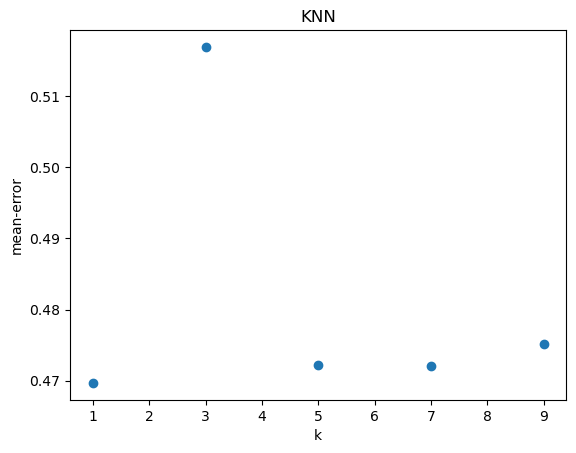

In [127]:
plot_results(k, errors)

In [128]:
k_high_tf_idf = optimal_k(errors)

### Experiment N=2

1. Weighting Method = tf_idf
2. Dimension = Low

In [129]:
k = 30
errors = tune_hyperparameter_k(run_kNN, X_train_low, y_train, k_train=k)

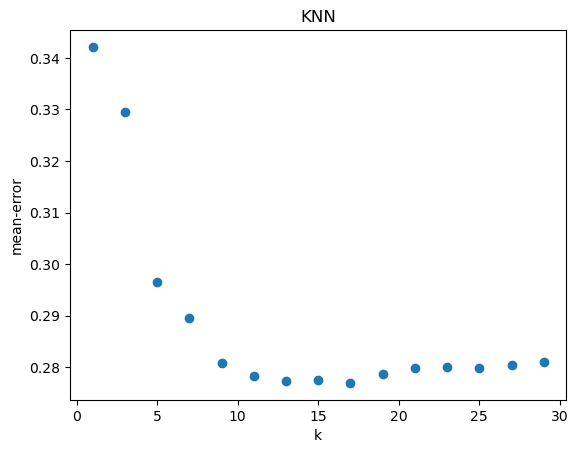

In [130]:
plot_results(k, errors)

In [131]:
k_low_tf_idf = optimal_k(errors)

### Experiment N=3

1. Weighting Method = tf
2. Dimension = high

In [132]:
k = 30
errors = tune_hyperparameter_k(run_kNN, X_train_tf, y_train, k_train=k)

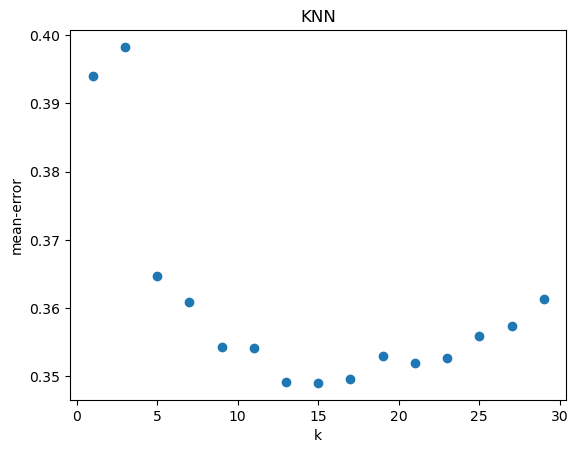

In [133]:
plot_results(k, errors)

In [134]:
k_high_tf = optimal_k(errors)

### Experiment N=4

1. Weighting Method = tf
2. Dimension = low

In [135]:
k = 100
errors = tune_hyperparameter_k(run_kNN, X_train_low_tf, y_train, k_train=k)

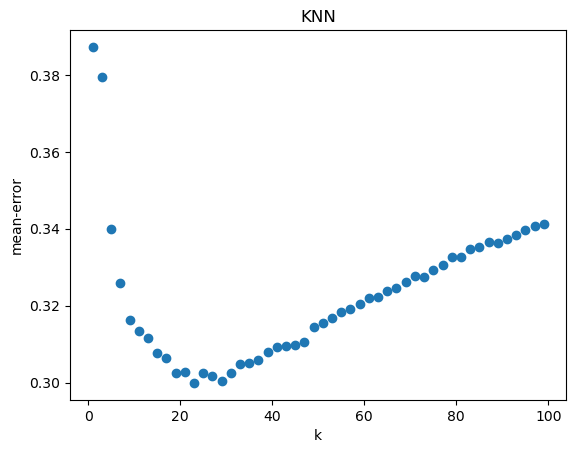

In [136]:
plot_results(k, errors)

In [137]:
k_low_tf = optimal_k(errors)

### Best kNN Model

In [138]:
bows = ['tf_idf', 'tf_idf_low', 'tf', 'tf_low']
ks = [k_high_tf_idf, k_low_tf_idf, k_high_tf, k_low_tf]

min_error = []
k_values = []
for model in ks:
    k, error = model
    min_error.append(error)
    k_values.append(k)

In [174]:
best_knn_model = {
    'k': k_values[min_error.index(min(min_error))],
    'model': bows[min_error.index(min(min_error))],
    'error': min(min_error)
}

best_knn_model

{'k': 17, 'model': 'tf_idf_low', 'error': 0.2769611890999174}

### 2. Naive Bayes for Classification

In [175]:
def train_NB(X_train, y_trainf, alpha):
    classifier = MultinomialNB(alpha=alpha).fit(X_train, y_train)
    return classifier

def eval_NB(classifier, X_eval):
    predictions = classifier.predict(X_eval)
    return predictions

def run_NB(X, y, X_validation, y_validation, alpha):
    classifier = train_NB(X, y, alpha)
    y_pred = eval_NB(classifier, X_validation)
    error = mean_zero_one_loss(y_validation, y_pred)
    
    return error

In [176]:
def tune_hyperparameters(classifier, X, y, X_validation, y_validation, n):
    errors = []
    
    for alpha in range(1, n + 1, 2):
        print(f"alpha = {alpha}", end="\r")
        errors.append(classifier(X, y, X_validation, y_validation, alpha))
    
    return errors
    

def plot_results_NB(errors, n):
    x = np.array(list(range(1, n+1, 2)), dtype=np.int8)
    
    plt.scatter(x, errors)
    plt.title("Naive Bayes")
    plt.xlabel("alpha")
    plt.ylabel("error")
    plt.show()

### Experiment N=5

1. Weighting Method = tf_idf
2. Dimension = high

In [177]:
n = 30
errors = tune_hyperparameters(run_NB, X_train, y_train, X_validation, y_validation, n)

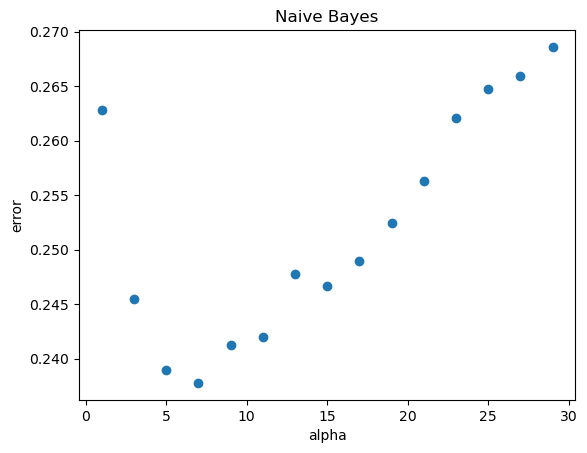

In [178]:
plot_results_NB(errors, n)

### Experiment N=6

1. Weighting Method = tf_idf
2. Dimension = low

In [179]:
n = 30
scaler = MinMaxScaler()
new_X_validation_low = scaler.fit_transform(X_validation_low)
new_X_train_low = scaler.fit_transform(X_train_low)
errors = tune_hyperparameters(run_NB, new_X_train_low, y_train, new_X_validation_low, y_validation, n)


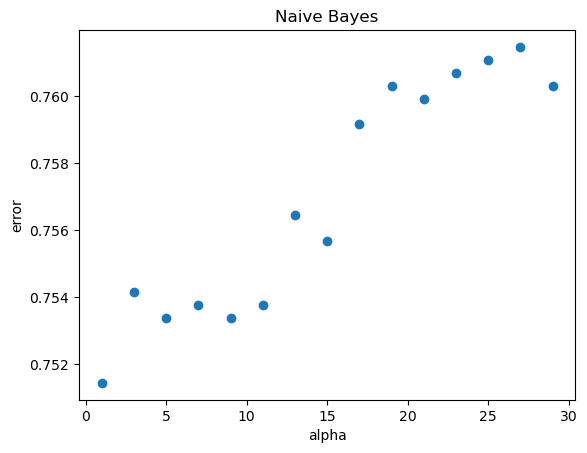

In [180]:
plot_results_NB(errors, n)

### Experiment N=7

1. Weighting Method = tf_idf
2. Dimension = high

In [181]:
n = 30
errors = tune_hyperparameters(run_NB, X_train_tf, y_train, X_validation_tf, y_validation, n)

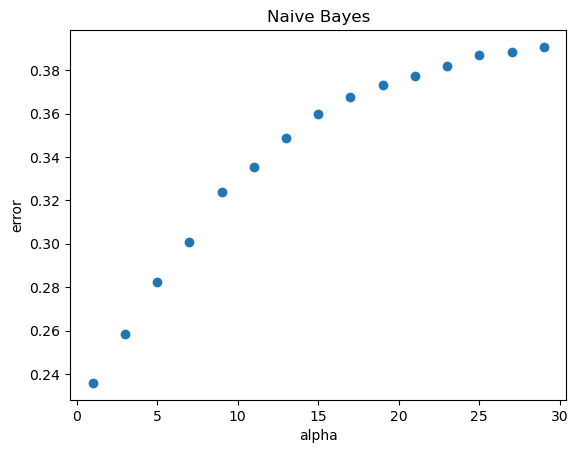

In [182]:
plot_results_NB(errors, n)

### Experiment N=8

1. Weighting Method = tf_idf
2. Dimension = high

In [183]:
n = 30
scaler = MinMaxScaler()
new_X_validation_low_tf = scaler.fit_transform(X_validation_low_tf)
new_X_train_low_tf = scaler.fit_transform(X_train_low_tf)
errors = tune_hyperparameters(run_NB, new_X_train_low_tf, y_train, new_X_validation_low_tf, y_validation, n)

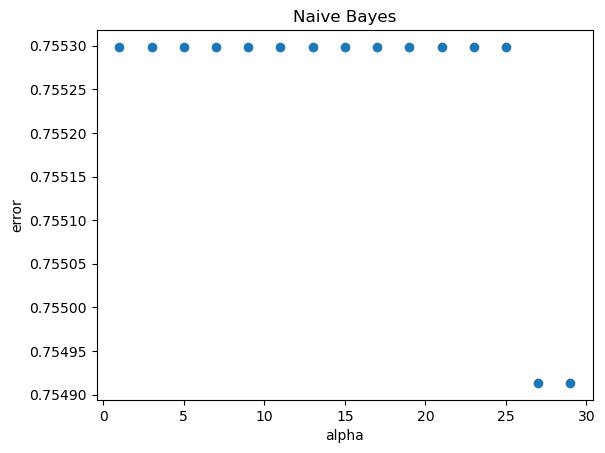

In [184]:
plot_results_NB(errors, n)

# Evaluation

Naive Bayesian Classification Algorithm should better not be used in NLP problems, because the LSA dimensionality reduction introduces new negative values, which are not allowed in Naive Bayesian algorithm. 

However, the best classification results has the given the Naive Bayesian algorithm, for high dimensionality matrix, with weighting method - tf_IDF.

In [191]:
n = 30
validation_errors = tune_hyperparameters(run_NB, X_train, y_train, X_validation, y_validation, n)

In [203]:
best_bayesian = {
    'model': 'tf_idf',
    'error': min(errors),
    'alpha': errors.index(min(errors)) * 2 + 1
}

best_bayesian

{'model': 'tf_idf', 'error': 0.23776493256262043, 'alpha': 7}

### Test and Validation Results for best KNN and Naive Bayesian hypermaterers tuning

In [216]:
knn_classifier = train_kNN(X_train_low, y_train, best_knn_model['k'])
test_predicts_knn = knn_classifier.predict(X_test_low)
validation_predicts_knn = knn_classifier.predict(X_validation_low)

naive_classifier = train_NB(X_train, y_train, best_bayesian['alpha'])
test_predicts_naive = naive_classifier.predict(X_test)
validation_predicts_naive = naive_classifier.predict(X_validation)

In [217]:
test_error_bayesian = mean_zero_one_loss(y_test, test_predicts_naive)
print('\n')
test_error_knn = mean_zero_one_loss(y_test, test_predicts_knn)

In [218]:
validation_error_bayesian = mean_zero_one_loss(y_test, validation_predicts_naive)
validation_error_knn = mean_zero_one_loss(y_validation, validation_predicts_knn)

In [220]:
result = {'Validation Error': [validation_error_knn, validation_error_bayesian], 
          'Test Error': [test_error_knn, test_error_bayesian],
          'Model': ['KNN Low (tf_idf)', 'Naive Bayesian High (alpha=7)']}

In [223]:
df = pd.DataFrame(data=result)
df

,Validation Error,Test Error,Model
0,0.689403,0.691715,KNN Low (tf_idf)
1,0.237765,0.237765,Naive Bayesian High (alpha=7)


# Confusion Matrix

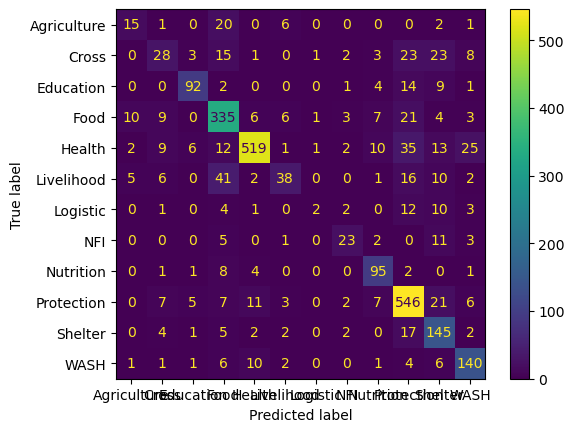

In [235]:
confusion_matrix = metrics.confusion_matrix(y_test, test_predicts_naive)

labels = ['Agriculture', 'Cross', 'Education', 'Food', 'Health', 'Livelihood', 'Logistic', 'NFI', 'Nutrition', 'Protection', 'Shelter', 'WASH']

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
cm_display.plot()

The biggest confusion is in Cross and Health classes.